# Project of Chara Spyropoulou, Marit van Arkel and Nikita Koster

# Introduction to Bioinformatics


**Computational design of a new ligand for p38**

**Pathology**

Cells get exposed to different types of stress during their lifetime. To induce cell and organism survival, these cells need to effectively cope with this stress. Therefore, the cells use several signalling networks (1). To regulate the cell growth, apoptosis and differentiation, extracellular signals are excreted. These are converted to intracellular signalling complexes due to mitogen-activated protein kinases (MAPK). One of the key signalling networks is p38 mitogen-activated protein kinase (p38 MAPK) (2). p38 kinase is activated by pro-inflammatory cytokines such as TNF-α and interleukins, as well as by the stimulation of certain receptors such as toll-like receptors and GPCRs (3). Through the activation of p38, the expression of cytokines, transcription factors, surface receptors and enzymes are regulated. Dysregulation of the p38 MAPK has been associated with multiple inflammatory diseases such as Alzheimer’s disease, asthma, brain inflammation, strokes, rheumatoid arthritis, systemic inflammation, inflammatory bowel disease and different forms of cancer due to its key role in the regulation of cytokine production, cell proliferation, apoptosis and cell invasion (4). Many attempts to achieve marketing authorization for a p38 MAPK inhibitor for the treatment of pro-inflammatory diseases have failed, which was mostly due to selectivity or toxicity issues (5).


**Clinical drugs available** 

According to the ChEMBL Target Report Card, no drug candidates are currently FDA-approved (5). Therefore, no Anatomical Therapeutic Chemical information is available. Since dysregulation of p38 plays a key role in many diseases and there is no FDA-approved drug developed yet, the investigation for a novel p38 MAPK inhibitor is crucial. 

**Protein information**

MAPK14 is one of the four identified p38 MAP kinases. The p38 MAPKs are in the family of MAPK-activated protein kinases. p38 kinase is a 41 kDa protein composed of 360 amino acids and is encoded on chromosome 6 in the genome. 





##### References

1.	Canovas B, Nebreda AR. Diversity and versatility of p38 kinase signalling in health and disease. Nat Rev Mol Cell Biol. 2021;22(5):346–66. 
2.	Kumar S, Boehm J, Lee JC. P38 MAP kinases: Key signalling molecules as therapeutic targets for inflammatory diseases. Nat Rev Drug Discov. 2003;2(9):717–26. 
3.	Hill RJ, Dabbagh K, Phippard D, Li C, Suttmann RT, Welch M, et al. Pamapimod, a novel p38 mitogen-activated protein kinase inhibitor: Preclinical analysis of efficacy and selectivity. Journal of Pharmacology and Experimental Therapeutics. 2008 Dec;327(3):610–9. 
4.	Yong HY, Koh MS, Moon A. The p38 MAPK inhibitors for the treatment of inflammatory diseases and cancer. Expert Opin Investig Drugs. 2009;18(12):1893–905. 
5.	Haller V, Nahidino P, Forster M, Laufer SA. Expert Opinion on Therapeutic Patents An updated patent review of p38 MAP kinase inhibitors (2014-2019)) An updated patent review of p38 MAP kinase An updated patent review of p38 MAP kinase inhibitors (2014-2019). Expert Opin Ther Pat. 2014;30(6):453–66. 



### Now, let's start with the fun part !
**Coding:**
* First, we added a code block that imports Python modules we want to work with. 

In [105]:
import nglview
import os
import shutil
from Bio.PDB import PDBParser, PDBIO, Select,  PDBList, MMCIFParser, StructureAlignment
import Bio.Align
import os
from pathlib import Path
import rdkit

# local scripts
from scripts import viewer
from scripts import bio_align

In [106]:
!pip install chembl_webresource_client
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

* In order to start working, we made a working directory in our home directory. 

In [107]:
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Bioinformatics')
except:
    print("Directory already exists")
os.chdir('Bioinformatics')

Directory already exists


* According to PDB, the protein ID is 3FLY. Here, we entered our target PDB code and made a 3D visualization of the protein. 

In [108]:
TARGET_PDB_ID = "3FLY" #Target PDB code

import nglview
view = nglview.show_pdbid(TARGET_PDB_ID)
view

NGLWidget()

* The co-crystallized ligand for 3FLY is FLY. This is visualized with the following code. 

In [109]:
LIGAND_CODE = "FLY" #Ligand code

view.center(LIGAND_CODE)
view

NGLWidget()

* To see the interactions between the ligand and the target protein, we visualized the amino acid residues around the ligand (within 5 Angstrom)

In [110]:
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

#### From the image below we can identify the interactions which are :

* Water bridge between the two Oxygens and ALA34A residue
* Hydrogen bonds between the Nitrogens and the MET109A residue
* Hydrophobic interactions between the carbons of aromatic ring and the residues ALA51A, LYS53A, LEU75A, ILE84A

 ![image info](img/3FLY_FLY_A_361.png)  


* Next, the coordinates were downloaded to generate a BioPython object. This is useful to split the protein and ligand and to save them seperately. 

In [111]:
pdbl = PDBList()
pdbl.retrieve_pdb_file(TARGET_PDB_ID, pdir=TARGET_PDB_ID)

'3FLY/3fly.cif'

* In this step, the ligand and protein were seperated and saved in seperate files so we can utilize the data. 


In [112]:
parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/3fly.cif'.format(TARGET_PDB_ID,TARGET_PDB_ID))

In [114]:
class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == LIGAND_CODE:
            return 1
        else:
            return 0

class NonHetSelect(Select):
    def accept_residue(self, residue):
        return 1 if residue.id[0] == " " else 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(LIGAND_CODE), ResSelect())         #Save ligand
io.save("protein-{}.pdb".format(TARGET_PDB_ID), NonHetSelect())

* In the previous code block, the ligand and protein were seperated. Now, the hydrogens will be added to the protein using LePro to be able to visualize all the interactions. First, the protein was prepared and then the protein and ligand files were combined. After that, the hydrogens were added to the protein. 

In [115]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(TARGET_PDB_ID)) #moves file to another destination 

'3FLY_prepped.pdb'

* Now, we visualized the ligand in the binding site of the protein, which now includes the hydrogen atoms, to have a better look at the interactions

In [116]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(TARGET_PDB_ID),
"ligand-{}.pdb".format(LIGAND_CODE)
]
with open('{}-complex.pdb'.format(TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [117]:
with open('{}-complex.pdb'.format(TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(LIGAND_CODE)
viewer.show_residues_around(view, selection=LIGAND_CODE)
view

NGLWidget()

**Visualizing similar proteins**

* Subsequently, we have repeated the steps for the visualization of the ligand-target interaction for 2 different proteins. The first protein, 3FLZ, is the most similar protein to 3FLY. The second protein, 6OPI, is the off-target protein and the highest hit from the PDB (which was not another p38 protein). 

In [118]:
SIMILAR_TARGET_PDB_ID = "3FLZ" #similar target PDB code 
SIMILAR_TARGET_LIGAND = "FLZ"  #similar target ligand code 

pdbl = PDBList()
pdbl.retrieve_pdb_file(SIMILAR_TARGET_PDB_ID, pdir=SIMILAR_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/3flz.cif'.format(SIMILAR_TARGET_PDB_ID,SIMILAR_TARGET_PDB_ID))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == SIMILAR_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(SIMILAR_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(SIMILAR_TARGET_PDB_ID), NonHetSelect())

In [119]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(SIMILAR_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(SIMILAR_TARGET_PDB_ID))

'3FLZ_prepped.pdb'

In [120]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(SIMILAR_TARGET_PDB_ID),
"ligand-{}.pdb".format(SIMILAR_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(SIMILAR_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [121]:
with open('{}-complex.pdb'.format(SIMILAR_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(SIMILAR_TARGET_LIGAND)
viewer.show_residues_around(view, selection=SIMILAR_TARGET_LIGAND)
view

NGLWidget()

* Now we visualize are off-target which is an ERK2 protein

In [122]:
OFF_TARGET_PDB_ID = "6OPI" #off target PDB code
OFF_TARGET_LIGAND = "N0V"  #off target ligand code 
pdbl = PDBList()
pdbl.retrieve_pdb_file(OFF_TARGET_PDB_ID, pdir=OFF_TARGET_PDB_ID)

parser = MMCIFParser()
structure = parser.get_structure("TARGETPROT",'{}/6opi.cif'.format(OFF_TARGET_PDB_ID,OFF_TARGET_PDB_ID))

class ResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_resname() == OFF_TARGET_LIGAND:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save("ligand-{}.pdb".format(OFF_TARGET_LIGAND), ResSelect())
io.save("protein-{}.pdb".format(OFF_TARGET_PDB_ID), NonHetSelect())

In [123]:
command = '../CBR_teaching/bin/lepro protein-{}.pdb'.format(OFF_TARGET_PDB_ID)
os.system(command)
shutil.move('pro.pdb','{}_prepped.pdb'.format(OFF_TARGET_PDB_ID))

'6OPI_prepped.pdb'

In [124]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(OFF_TARGET_PDB_ID),
"ligand-{}.pdb".format(OFF_TARGET_LIGAND)
]
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [125]:
with open('{}-complex.pdb'.format(OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center(OFF_TARGET_LIGAND)
viewer.show_residues_around(view, selection=OFF_TARGET_LIGAND)
view

NGLWidget()

**Aligning our protein with the off-target protein**

* In the next step, the structures of the target protein and the off-target protein were aligned. This way we were able to compare the structures of the proteins and the co-crystalized ligands.  

In [66]:
from Bio import pairwise2
from Bio.Seq import Seq 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

# Get the structures
PDBCODE_1 = '3FLY' # Name of the first structure
PDBCODE_2 = '6OPI' # Name of the second structure

import requests
data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_1}').json()[PDBCODE_1.lower()]
SEQ1 = (data[0]['sequence'])
SEQ1 = Seq(SEQ1)

data = requests.get(f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{PDBCODE_2}').json()[PDBCODE_2.lower()]
SEQ2 = (data[0]['sequence'])
SEQ2 = Seq(SEQ2)

alignments = pairwise2.align.globalxx(SEQ1, SEQ2)

for align1, align2, score, begin, end in alignments:
    filename = "alignment.fasta"
    with open(filename, "w") as handle:
        handle.write(">SEQ1\n%s\n>SEQ2\n%s\n" % (align1, align2))

print(alignments[0])

Alignment(seqA='MRGSHHHHHHGSMSQER--PTFY---R-QELNKTIWEV----PERYQ-NLSPV--GS-GAYGS-VCA-AF-DT---KTGL-RVAV-KKL-SRPFQSII-HAKR-TY--RE-LR----LLKHMK---HENVI-GLL--DVFTPA--RSLE----EFN---DVYL-VTH--LMGA--DLNNIVKCQ-KL--TD-----DHVQ---FLIYQILRGLKYIHSADII---HRDLKPSNLAV--NED--CE-LKIL-DFGLARHT--D-DEM---TG----YVATRWYRAPEIMLNWMH---YNQTV---DIWSVGCIM-AEL-LTG--RTL--FPGTD-HI--DQLKL--ILR--LVGT-PGA--E-L-----LKKISSESARNYIQ--SLTQMP-KMNFAN-VFIGANP---L---AVD---L-LE--KMLVLDSD-----KRITAA---QALAHA-YFA--QYH-DPD-DEPV-AD--PYDQSFESR--DL--LID----EWKSLTYD-EV-ISFVPPPLDQEEME---------S', seqB='---S------G------AGP---EMVRGQ--------VFDVGP-RY-TNLS--YIG-EGAYG-MVC-SA-YD-NVNK---VRVA-IKK-IS-PF----EH---QTYCQR-TLREIKILL----RFRHEN-IIG--IND-----IIR---APTIE--QMKDVY-IV--QDLM--ETDL-------YKLLKT-QHLSNDH--ICYFL-YQILRGLKYIHSA---NVLHRDLKPSNL--LLN--TTC-DLKI-CDFGLAR--VADPD--HDHTGFLTEYVATRWYRAPEIMLN---SKGY--T-KSIDIWSVGCI-LAE-ML--SNR--PIFPG--KH-YLDQ--LNHIL-GIL-G-SP--SQEDLNCIINL-K-----ARNY--LLSL---PHK----NKV-----PWNRLFPNA-DSKALDL-LDKM--L---TFNPHKRI--

In [67]:
bio_align.run('{}-complex.pdb'.format(TARGET_PDB_ID),'{}-complex.pdb'.format(OFF_TARGET_PDB_ID))

/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing occupancy at line 2.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing B factor at line 2.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing occupancy at line 3.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/Bio/PDB/PDBParser.py

In [68]:
# combine protein and ligand files
filenames = [
'{}-complex.pdb'.format(TARGET_PDB_ID,TARGET_PDB_ID),
"{}-complex_transformed.pdb".format(OFF_TARGET_PDB_ID)
]
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)
                    
with open('{}-{}-merged.pdb'.format(TARGET_PDB_ID,OFF_TARGET_PDB_ID)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view

NGLWidget()

* From the animation above we conclude that 3FLY and 6OPI are quite aligned. The ligands are also aligned but the ligand of the off-target 6OPI is much bigger. Because the off-target ligand is different from our reference ligand we expect that FLY has a lower binding affinity to the off-target.

**Alignment of the 3FLY-3FLZ and 3FLY-6OPI**

* The 3FLY and 3FLZ proteins align almost perfectly, which can be seen in the generated picture below. There are some small differences that can be seen when zooming in on the structure. Both are P38 kinase structures so it was expected that they would be very similar. 


3FLY/3FLZ: ![image info](img/PROTEINS_SIMILAR.png) 
3FLY/6OPI![image info](img/3FLY_6OPI.png)
Alligning with: https://www.ncbi.nlm.nih.gov/Structure/icn3d/full.html

  
  
  
FLZ interactions:![image info](img/FLZ_INTERACTIONS.png)
OPI interaction:![image info](img/OPI_INTERACTIONS.png)



**Important interactions**

* The image above shows the interactions between the protein and the ligand (FLZ and OPI, respectively). For FLY the most important interactions are 3 hydrogen bonds (one N-H , two O-H). FLZ almost has the same interactions, 2 hydrogen bonds (N) and 2 waterbridges (O). However, it has an extra hydrogen bond due to the additional oxygen atom in the ringstructure. Lastly, the interactions of the off target ligand are: 13 hydrophobic interactions, 4 hydrogen bonds, 3 water bridges, 1 pi-stacking and 1 salt bridge. 


**Improve the ligand**

* The two oxygen atoms and the nitrogen atoms showed to be important in the structure so we want to keep those in our new ligand. Besides, we could try to add more hydrogen bonds.

# Machine Learning


* In the section 'Machine Learning', we will look into the classification of the ligands using three algorithms: Random Forest, Support Vector Machine and Artificial Neural Network. We will do this to test whether the model can predict new data. 

* In the Bioinformatics part, we looked into the interaction of the ligand and the target and off target protein. In this part, we found that there are several important interactions between the ligand and the target protein: 

   * Water bridge between the two Oxygen atoms and ALA34A residue
   * Hydrogen bonds between the Nitrogen atoms and the MET109A residue
   * Hydrophobic interactions between the carbon atoms of the aromatic ring and the residues ALA51A, LYS53A, LEU75A, ILE84A

* This is supported by the study of (Ottosen et al., 2003), which suggests that the double bound oxygen atom and the amine group in a ligand are crucial for proper interaction.  

Ottosen, E. R., Sørensen, M. D., Björkling, F., Skak-Nielsen, T., Fjording, M. S., Aaes, H. & Binderup, L. (2003). Synthesis and Structure−Activity Relationship of Aminobenzophenones. A Novel Class of p38 MAP Kinase Inhibitors with High Antiinflammatory Activity. Journal of Medicinal Chemistry, 46(26), 5651–5662. https://doi.org/10.1021/jm030851s

**Reference ligand FLY:** 


![image info](img/FLY_INFO.png)

In [69]:
!pip install chembl_webresource_client

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [70]:
# We will load libraries again 
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# We silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
#seed_everything(SEED)

* Using the Similarity search on PubChem, over 426 similar compounds were found with 90% similarity. This number increased when we changed the Tanimoto threshold to 80% with over 1000 similar compounds. 

In [71]:
def seed_everything(seed=22):
    """Set the RNG seed in Python and Numpy"""
    import random
    import numpy as np

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [72]:
import os
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Cheminformatics')
except:
    print("Directory already exists")
os.chdir('Cheminformatics')

Directory already exists


In [73]:
CHEMBLID = 'CHEMBL260' #CHEMBL ID of 3FLY
FILENAME = 'CHEMBL260.tsv' #filename 

data = pd.read_csv(f"../{FILENAME}", sep='\t')

print("There are a total of {} datapoints in this set".format(len(data)))
data.head()

There are a total of 12522 datapoints in this set


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL215152,AZD-1152-HQPA,0,507.57,1,3.50,SID103905345,CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[...,Ki,'>',...,MAP kinase p38 alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1147984,1,Scientific Literature,J. Med. Chem.,2007.0,None,NaN
1,CHEMBL202891,GW679410X,0,328.38,0,4.21,GW679410X,COc1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3)ccn2)cc1,Inhibition,'=',...,MAP kinase p38 alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1961873,16,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN
2,CHEMBL365248,GW810372X,0,402.34,0,3.84,GW810372X,COc1ccc2c(-c3ccnc(Nc4cccc(OC(F)(F)F)c4)n3)cnn2n1,Inhibition,'=',...,MAP kinase p38 alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1961873,16,GSK Published Kinase Inhibitor Set,NaN,NaN,None,NaN
3,CHEMBL360302,NaN,0,227.29,0,3.06,9,c1ccc(Sc2[nH]cnc3nccc2-3)cc1,Inhibition,'=',...,MAP kinase p38 alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1141882,1,Scientific Literature,J. Med. Chem.,2005.0,None,NaN
4,CHEMBL408876,NaN,0,429.50,1,5.37,29,O[C@H]1CC[C@H](n2cnc(-c3ccc(F)cc3)c2-c2ccnc(Nc...,IC50,'=',...,MAP kinase p38 alpha,Homo sapiens,SINGLE PROTEIN,CHEMBL1134743,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2001.0,None,NaN


* The total of datapoints is 12522

In [74]:
pd_data = data[['Molecule ChEMBL ID','pChEMBL Value','Smiles','Assay Type', 'Standard Relation','Standard Value']] #include data types
pd_data.rename(columns={'pChEMBL Value': 'pChEMBL_value', 'Assay Type':'Assay_Type'}, inplace=True)
pd_data.head()

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value
0,CHEMBL215152,NaN,CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[...,B,'>',10000.00
1,CHEMBL202891,NaN,COc1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3)ccn2)cc1,B,'=',7.92
2,CHEMBL365248,NaN,COc1ccc2c(-c3ccnc(Nc4cccc(OC(F)(F)F)c4)n3)cnn2n1,B,'=',2.92
3,CHEMBL360302,NaN,c1ccc(Sc2[nH]cnc3nccc2-3)cc1,B,'=',56.00
4,CHEMBL408876,8.82,O[C@H]1CC[C@H](n2cnc(-c3ccc(F)cc3)c2-c2ccnc(Nc...,B,'=',1.50


In [75]:
import numpy as np
# Add column for activity
pd_data["active"] = np.zeros(len(pd_data))

# Molecules with an pCHEMBL of >= 6.5 are marked active(1), 0 otherwise
pd_data.loc[pd_data[pd_data.pChEMBL_value >= 6.5].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(pd_data.active.sum()))
print("Number of inactive compounds:", len(pd_data) - int(pd_data.active.sum()))

Number of active compounds: 3955
Number of inactive compounds: 8567


* The total number of active compounds in this dataset is 3955
* The total number of inactive compounds in this dataset is 8567

The larger amount of inactive compounds was not unexpected due to the large dataset

* We now filter the data so we exlude the data which is not assay type B

In [76]:
pd_data.drop(pd_data[pd_data.Assay_Type != 'B'].index, inplace=True)

print("We have a total of {} activity points left".format(len(pd_data)))

We have a total of 12051 activity points left


* This leaves us with 12051 activity points

In [77]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

* In the next step, we generate fingerprints from the SMILES of the molecules. This is done to translate the molecule into a formulation that works better in Python. 

In [78]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    try:
        mol = Chem.MolFromSmiles(smiles)
        
    except:
        return('NaN')

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [79]:
compound_df = pd_data.copy()

* In this step, we add a column in the table for the fingerprints. 

In [80]:
# Add column for fingerprint
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.drop(compound_df[compound_df.fp == 'NaN'].index, inplace=True)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Molecule ChEMBL ID,pChEMBL_value,Smiles,Assay_Type,Standard Relation,Standard Value,active,fp
0,CHEMBL215152,NaN,CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[...,B,'>',10000.00,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL202891,NaN,COc1ccc(-c2cc(-c3c[nH]nc3-c3ccccn3)ccn2)cc1,B,'=',7.92,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL365248,NaN,COc1ccc2c(-c3ccnc(Nc4cccc(OC(F)(F)F)c4)n3)cnn2n1,B,'=',2.92,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


* After this, we started with the Machine Learning part as described above. We first defined the function model_training_and_validation. This fits the model on the random train-test split of our data and returns evaluation values like the accuracy and AUC. 

* In the next code block, a helper function is made in order to plot the ROC curves. 

In [81]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=True):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"results/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

* The next code block is a helper function to calculate the performance of the model.

In [82]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

* The next code block describes a helper function to make sure the machine learning model fits on the random train-test split of the data. Besides that, it returns the performance rates. This is useful because we need these values in further steps. 

In [83]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

* In the next step we preprocess the data which means we split it to create a training set and a test set. 

In [84]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 9588
Test data size: 2398


* This results in a training data set of 9588 compounds and a test data set of 2398 compounds (ratio: 80/20)

**Testing the different algorithms**

* We first start with the random forest classifier, which is trained on a random train-test split

In [85]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [86]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.74
Specificity: 0.87
AUC: 0.90


This gives approximately:

    Sensitivity:  0.73
    
    Specificity: 0.88
    
    AUC: 0.90
    
This can differ in every run time due to the random split

* We now plot a ROC curve of random forest 

Directory already exists, continuing


'/home/jovyan/Cheminformatics/results/roc_auc.png'

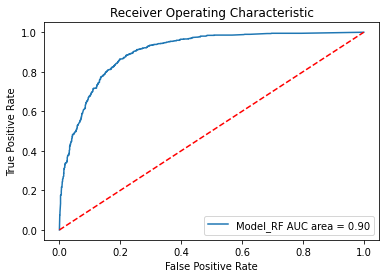

In [87]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
try:
    os.mkdir('results')
except:
    print("Directory already exists, continuing")
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

* The RF model lies far above the random model (red line) which is promising of a good performance of this model 

* We now train a support vector classifier (SVM) classifier

In [88]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.73
Specificity: 0.90
AUC: 0.90


This gives approximately:

    Sensitivity:  0.73
    
    Specificity: 0.90
    
    AUC: 0.90
    
This can again differ due to the random split. 


'/home/jovyan/Cheminformatics/results/roc_auc.png'

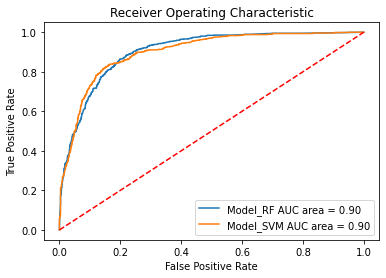

In [89]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

* Lastly, we train a multi-layer perceptron classifier (MLPClassifier), which has 3 layers, with each 5 neurons. 

In [ ]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=12)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

This gives approximately:

    Sensitivity:  0.69
    
    Specificity: 0.86
    
    AUC: 0.88
    
This is lower than the RF and SVM model. 

In [ ]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)
result_img = '{}/results/roc_auc.png'.format(os.getcwd())
result_img

* All models lie far above the random model. However the SVM model shows to be most promising.

**Cross validation**

* We now perform a cross validation to compare the machine learning models. So we test the ability of the models to predict new data

In [ ]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [ ]:
N_FOLDS = 3 #split data in 3 groups

In [ ]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)

* Looking at this data the SVM model is the most promising one but it takes longer to run compared to the other ones. The AUC value is higher than the ANN model and has a higher accuracy/specificity than the RF model.

**Cross-validation with morgan fingerprint (instead MACCS)**

In [ ]:
# Reset data frame
compound_df = compound_df.drop(['fp'], axis=1)

In [ ]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

In [ ]:
for model in models:
    if model["label"] == "Model_SVM":
        continue
    print("\n=======")
    print(model["label"])
    reduced_df = compound_df[['active','fp']]
    crossvalidation(model["model"], reduced_df, n_folds=N_FOLDS)

* SVM was excluded due to runtime but had similar results as the RF model
* Again the ANN model shows to be the least promising

Make a new function that works with regression: 

In [ ]:
def crossvalidation_reg(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    MAE_per_fold = []
    RMSE_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].pChEMBL_value.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].pChEMBL_value.tolist()
        
        test_results = fold_model.predict(test_x)
        # Prediction probability on test set
        from sklearn import metrics

        MAE_per_fold.append(metrics.mean_absolute_error(test_y, test_results))
        #print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, test_results))
        RMSE_per_fold.append(np.sqrt(metrics.mean_squared_error(test_y, test_results)))
        #mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
        #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
        #print('Accuracy:', round(100*(1 - mape), 2))
    return(MAE_per_fold,RMSE_per_fold,fold_model)

* Split data into 80% training set and 20% test set

In [ ]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.pChEMBL_value.tolist()

# Split data randomly in train and test set
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=12)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

* To determine if our model can accurately predict data we calculated the mean absolute error and root mean square error

In [ ]:
# Kick out NaN in the pChEMBL values
compound_df_noNaN = compound_df.dropna()

# Append RF Regressor model
#models.append({"label": "Model_RF_reg", "model": RandomForestRegressor})
#Train model with RandomForestRegressor
regressor = RandomForestRegressor()
MAE, RMSE,trained_model = crossvalidation_reg(regressor , compound_df_noNaN, n_folds=N_FOLDS)

print(
f"MAE: {np.mean(MAE):.2f} \t"
f"and std : {np.std(MAE):.2f} \n"
f"RMSE: {np.mean(RMSE):.2f} \t"
f"and std : {np.std(RMSE):.2f} \n"
)

* The values of MAE/RMSE should be close to 0 (0.6 is considered quite decent). 
* Our error is relatively high but still decent enough to continue

In [ ]:
# The first entry is the co-crystalized ligand 
# which is added for reference 
test_smiles = [
    
    'CCC(C)NC1=NC=C2C=C(C(=O)N(C2=N1)C)OC3=C(C=C(C=C3)F)F', #FLY
    'FC1=CC=C(OC2=CC3=C(N=C(NC(C)C4CC4)N=C3)N(C)C2=O)C(F)=C1', #Group 1
    'FC1=CC=C(OC2=CC(C=NN3CCC)=C3C=C2C(NCCN(C)C)=O)C(F)=C1', #Group 1
    'FC1=CC=C(OC2=CC(C=NN3CC(C)(C)C)=C3C=C2C(NCCN(C)C)=O)C(F)=C1', #Group 1
    'FC1=CC=C(OC2=CC(C=NN3CCC(C)C)=C3C=C2C(NCCN(C)C)=O)C(F)=C1', #Group 1
    'FC1=CC(F)=CC=C1SC2=NN(C=NC3=O)C(C=C2)=C3C4=C(Cl)C=CC=C4Cl', #Group 1
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)(C)C)=O)C=C3)=CC(F)=C2', #Group 2
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCCC)=O)C=C3)=CC(F)=C2', #Group 2
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)C(C)C)=O)C=C3)=CC(F)=C2', #Group 2
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)CC)=O)C=C3)=C(C)C(F)=C2', #Group 2
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)C(C)C)=O)C=C3)=CC(F)=C2', #Group 1
    'FC1=CC(F)=CC=C1OC2=C(C(NCCN(C)C)=O)C=C(N(CC(C)=O)N=C3)C3=C2', #Group 3
    'CCc1sc(c2cc(NC(c3ccccc3C)=O)ncc2)c(c4cc(C)ccc4)n1', #Group 4
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C=C2C(NCCN(C)C)=O)N(CC(C)C)N=C3', #Group 4
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C=C2C(NCCN(C)C)=O)N(CC(C)(C)C)N=C3', #Group 4
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C(C)=C2C(NCCN(C)C)=O)N(CC(C)C)N=C3',  #Group 1
    'O=C1C(OC2=CC(F)=CC=C2)=CC3=CN=C(NC4CCOCC4)N=C3N1C5=CC=CC=C5' #

]

fps = []

for smiles in test_smiles: 
    fp = smiles_to_fp(smiles,'morgan3')
    fps.append(fp)

predictions = trained_model.predict(fps)
print("SMILES, PREDICTION")
for i, prediction in enumerate(predictions):
    print('{},{:.2f}'.format(test_smiles[i], prediction))

**Explanation of SMILES included**

* Based on our training set we created a prediction model so we can compare the reference with new generated ligands.
* The first string of SMILES is of FLY as reference. Our new ligand should have a higher prediction value than FLY. 
* To create new ligands we looked for known ligands in our data set that reached clinical phase 2 or 3. 
* We modified the structure of those ligands based on the important interactions we have seen.



After running the prediction model, our prediction data showed that none of these ligands actually showed a higher prediction value. The prediction value of the reference (FLY) is at the moment of this run: 8.14. However, this predicted value differs from 6.5-8.2 between different runs.  According to ChEMBL the pChEMBL values are also ranging from 5.38 to 8.40. Because it is quite a big range it is hard to say if the predicted values comply with the available data. 

Because we did not find any improvement in our newly created models, we decided to devide our data in different groups (1-4). The groups were devided into the different scaffolds they have (which were based on the known ligands) and different side groups were added. In this way we hope to see patterns within scaffolds and side groups. 
The group that showed the best prediction values was group 1. Within the groups, a large carbon chain seems to have a negative effect on the prediction value. This means that:
- The best scaffold, of the tested scaffolds, is the scaffold similar to our reference ligand 
- Large carbon chains are not beneficial for the ligands

In the next part we will dock the proteins of group 1. We are interested if pCHEMBL values agree with the prediciton values. Besides, we hope to get a better insight into how the new ligands bind to the protein (and possibly see why they do not have a good binding affinity)

**Discussion**

* All models seemed to perform well on our dataset. However, the RF and VSM model showed to perform better than the ANN model. Both AUC values were 0.90 while the AUC value of ANN was lower, 0.88. 
* Our data set was around 12.000 compounds which should be enough for using an ANN model. However, it would be more accurate if we had more data points (or more complex data). This could be the reason why the AUC value is slightly lower. 
* The VSM model was very slow and we therefore proceeded with the RF model

* Using morgan finger prints instead of MACCS resulted in higher AUC values, possibly because the morgan fingerprints contains more bits and thus more data. However, the running time of the morgan fingerprints was longer than of MACCS and VSM took very long to run
* So MACCS was a good starting point, however the model did perform slightly better with morgan fingerprints. 

* Finally, our model seemed to be acceptable. The MAE/RMSE were close to 0.6. 

## Molecular docking

* Now, we proceed with docking. In order to use AutoDock, we first have to install the open drug discovery toolkit

In [ ]:
!pip install oddt

In [ ]:
# Now we install AutoDock Vina
!pip install vina

* We also need to import some libraries in order to do docking 

In [ ]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
from scripts import viewer

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')


import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

* Following the same strategy as before, we are going to make a new environment to work in and put in files.

In [ ]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

#### 1. The first step is to cleanup the system 
* Now we need to copy the folder of the prepared protein 3FLY from the previous steps in this folder:

In [ ]:
PDBCODE = '3FLY' # PDB accession code
LIGAND_CODE = 'FLY' # ligand code
shutil.copy('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE))
shutil.copy('../Bioinformatics/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

* Now, we will generate the 3D coordinate files of each of the ligands. We are going to use the smiles we generated from the previous step.

In [ ]:
test_smiles = [
    
    'CCC(C)NC1=NC=C2C=C(C(=O)N(C2=N1)C)OC3=C(C=C(C=C3)F)F', #FLY
    'FC1=CC=C(OC2=CC3=C(N=C(NC(C)C4CC4)N=C3)N(C)C2=O)C(F)=C1', #NEW
    'FC1=CC=C(OC2=CC(C=NN3CCC)=C3C=C2C(NCCN(C)C)=O)C(F)=C1',
    'FC1=CC=C(OC2=CC(C=NN3CC(C)(C)C)=C3C=C2C(NCCN(C)C)=O)C(F)=C1', 
    'FC1=CC=C(OC2=CC(C=NN3CCC(C)C)=C3C=C2C(NCCN(C)C)=O)C(F)=C1',
    'FC1=CC(F)=CC=C1SC2=NN(C=NC3=O)C(C=C2)=C3C4=C(Cl)C=CC=C4Cl',
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)(C)C)=O)C=C3)=CC(F)=C2',
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCCC)=O)C=C3)=CC(F)=C2',
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)C(C)C)=O)C=C3)=CC(F)=C2',
    'O=C(NC1CC1)C2=CC(C3=NC=C(C(NCC(C)CC)=O)C=C3)=C(C)C(F)=C2',
    'FC1=CC(F)=CC=C1OC2=C(C(NCCN(C)C)=O)C=C(N(CC(C)=O)N=C3)C3=C2',
    'CCc1sc(c2cc(NC(c3ccccc3C)=O)ncc2)c(c4cc(C)ccc4)n1',
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C=C2C(NCCN(C)C)=O)N(CC(C)C)N=C3',
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C=C2C(NCCN(C)C)=O)N(CC(C)(C)C)N=C3',
    'FC1=CC=C(C(F)=C1)OC2=CC3=C(C(C)=C2C(NCCN(C)C)=O)N(CC(C)C)N=C3',
    'O=C1C(OC2=CC(F)=CC=C2)=CC3=CN=C(NC4CCOCC4)N=C3N1C5=CC=CC=C5'
]

* We will add automatic numbers for the ligands in order to be called ligand_00,ligand_01 etc. Also, we will generate the 3D files using rdkit.
* With the below code we will prepare the molecules for the docking by adding hydrogens

In [ ]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img

#### 2. System Visualization
* With this code we can visualize the binding site of the protein and the reference ligand docked in it.

In [ ]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

* As we can see in the scheme above the green molecule is not docked in the binding site and that is expected due to lack of coordinate information. The regeneration of of the molecule from scratch means that the information about the coordinates does not exist anymore so it is outside of the protein.

#### 3. Docking with AutoDock Vina
AutoDock Vina is an open-source program for doing molecular docking. We use AutoDock Vina because it is faster than AutoDock4.

##### 3.1 Protein and Ligand preparation.
* In order to do docking we have to convert the files into PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand.

* With this code we are going to prepare the protein and the molecules (ligands)

In [ ]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

#### 3.2 Box definition
* With the above code we are going to calculate the radius of gyration, as well as the center of geometry of the ligand to define the box size. We do this to generate an efficient box for the docking process.

In [ ]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

In [ ]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

#### 3.4 Docking
* We are going to do docking for each of the ligands we generated seperately and visually examine the results.

* But first we need to prepare the the protein and the ligand for the docking.

In [ ]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [ ]:
# Here we change each time the name of the ligand:
# So, ligand_00 is the reference ligand from the crystal structure
# Then, ligand_01, ligand_02, ... etc. until we docked every generated molecule
# We will run one ligand at the time.
LIGAND_TO_DOCK = 'ligand_13' # Here we write the number of the ligand we want to dock
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

* Now we are ready for the actual docking. 

In [ ]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)

In [ ]:
# We create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

####  3.5 3D visualization of docking results
* With the below code we will be able to visualize the ligand docked into the protein and compare the results with the reference ligand (FLY).

In [ ]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

In [ ]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [ ]:
# docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK

with open('{}-complex.pdb'.format(PDBCODE)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
viewer.show_residues_around(view, selection="UNL")
view

#### 3.6 Analyzing the results

A freezed image of the docking of the aligned ligand_15 with the reference ligand:
 ![image info](img/Ligand_15_alignment.png)  

Docking with the reference molecule was first done in order to compare it with the generated molecules. After running the code several times to dock every novel molecule, we concluded that the best molecule was ligand_15.

Now, we are going to discuss the results of docking the ligand with the code : ligand_15
Firstly, the ligand has lower pCHEMBL value than the reference ligand although ligand_15 fits nicely in the binding pocket.
Ligand_15  was probably the best novel ligand out of the fifteen novel ligands we ceated due to the remained interactions of the main scaffold and the additional hydrogen bond.

The prediction score does not exactly reflect the values from the docking. However, it has the same trend: lower prediction values also had lower docking values, with some exceptions. The docking value was in general lower than the predicition score. 


#### Discussion
The biggest limitation of our project was time. We created new ligands and docked them however there are still a lot of improvements that can be made for a more accurate model. First, we could filter our data more. Now, we only filtered our data based on the assay type and NAN’s but not yet on duplicates. This could improve our data set and subsequently our training model. Besides, we did a random split which can make the model overoptimistic. Therefore, we could change the random split with a temporal split. Also, we used a random forest regressor because of time. However, the VSM showed slightly better results so we could try to use this instead.  This could make our prediction model more accurate. 
Thereafter, we could generate molecules using DrugEx instead of creating own ligands trough ChemDraw. This could lead to a much larger data set of potential new ligands and therefore more chance to find a novel ligand for p38. 
Finally, to improve the docking there two improvements that could be made. First, we can utilize interaction fingerprints in addition to Morgan fingerprints. The interaction fingerprints will give information on the interaction of the ligand with the protein. This can lead to a more accurate docking score. Lastly, in our project we used auto dock vina, which is the best open source algorithm. However, it is still not the best. That is why, we could use different, more accurate, docking algorithms. 
To conclude, our ligand was not improved compared to the reference but using the above improvements we might get a better novel ligand. 
